# Density PDF emulator

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from sunbird.emulators import FCN, train
from sunbird.data import ArrayDataModule

plt.style.use(os.path.join(os.path.abspath('../'), 'plot_style.mplstyle'))

%load_ext autoreload
%autoreload 2

In [2]:
variation = 'cosmo+hod'
r = 10

if variation == 'hod':
    data_dir = Path('/pscratch/sd/m/mpinon/density/training_sets/hod/c000_ph000/seed0/')
elif variation == 'cosmo+hod':
    data_dir = Path('/pscratch/sd/m/mpinon/density/training_sets/cosmo+hod/ph000/seed0/')
data_fn = Path(data_dir) / 'pdf_r{:d}_lhc_cut.npy'.format(r)
lhc = np.load(data_fn, allow_pickle=True,).item()

In [3]:
delta = lhc['delta']
lhc_x = lhc['lhc_x']
lhc_x_names = lhc['lhc_x_names']
lhc_y = lhc['lhc_y']

In [4]:
nhod = int(len(lhc_y) / 85)
ntot = len(lhc_y)
idx_train = list(range(nhod * 6, ntot))
idx_test = list(range(0, nhod * 6))

In [5]:
#n = len(lhc_y)
#test_frac = 0.1
#n_val = int(np.round(test_frac * n))

In [6]:
lhc_train_x = lhc_x[idx_train]
lhc_train_y = lhc_y[idx_train]
lhc_test_x = lhc_x[idx_test]
lhc_test_y = lhc_y[idx_test]   

## Load model and test it

In [7]:
# Compare to cosmic variance

# rescale cov to the volume of the abacus mocks
prefactor = 1 / 64

# Read small boxes measurements for covariance
data_dir = Path('/pscratch/sd/m/mpinon/density/cov/')
data_fn = Path(data_dir) / 'pdf_r{:d}_cov_lhc_cut.npy'.format(r)
lhc_cov_pdf = np.load(data_fn, allow_pickle=True,).item()
cov_pdf = prefactor * np.cov(lhc_cov_pdf['lhc_y'], rowvar=False)
mean_pdf = np.mean(lhc_cov_pdf['lhc_y'], axis=0)
std_pdf = np.diag(cov_pdf)**0.5

In [15]:
# To load a model from a saved checkpoint:
#checkpoint_fn = "/global/homes/m/mpinon/density/emulator/pdf/r10/{}/last-v6.ckpt".format(variation)
transform = ''

em_err_list = list()
if r==10:
    versions = np.arange(20) 
elif r==15:
    versions = np.arange(8)
else:
    versions = np.arange(18)

for v in versions:
    if v==0:
        checkpoint_fn = "/pscratch/sd/m/mpinon/density/trained_models/pdf/r{:d}/{}/optuna/{}/last.ckpt".format(r, variation, transform)
    else:
        checkpoint_fn = "/pscratch/sd/m/mpinon/density/trained_models/pdf/r{:d}/{}/optuna/{}/last-v{:d}.ckpt".format(r, variation, transform, v)
    model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
    model = model.to('cpu')

    # and now let's test it
    model.eval()
    with torch.no_grad():
        pred_test_y  = model.get_prediction(torch.Tensor(lhc_test_x))
    pred_test_y = pred_test_y.numpy()
    pred_test_y = pred_test_y

    emulator_error = (pred_test_y - lhc_test_y)/std_pdf
    error_median = np.median(np.abs(emulator_error), axis=0)
    em_err_list.append(error_median)

best = versions[np.argmin(np.mean(np.array(em_err_list), axis=1))]
print(best)

15


In [16]:
if best==0:
    checkpoint_fn = "/pscratch/sd/m/mpinon/density/trained_models/pdf/r{:d}/{}/optuna/{}/last.ckpt".format(r, variation, transform)
else:
    checkpoint_fn = "/pscratch/sd/m/mpinon/density/trained_models/pdf/r{:d}/{}/optuna/{}/last-v{:d}.ckpt".format(r, variation, transform, best)
model = FCN.load_from_checkpoint(checkpoint_fn, strict=True)
model = model.to('cpu')

# and now let's test it
model.eval()
with torch.no_grad():
    pred_test_y  = model.get_prediction(torch.Tensor(lhc_test_x))
pred_test_y = pred_test_y.numpy()
pred_test_y = pred_test_y

emulator_error = (pred_test_y - lhc_test_y)/std_pdf
error_median = np.median(np.abs(emulator_error), axis=0)
em_err_list.append(error_median)


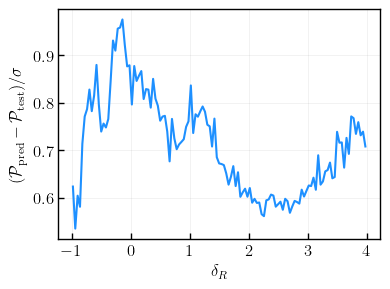

In [17]:
plt.figure(figsize=(4, 3))
plt.plot(delta, error_median)
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$(\mathcal{P}_{\mathrm{pred}} - \mathcal{P}_{\mathrm{test}})/\sigma$')
#plt.ylim(ymax=2)
plt.show()

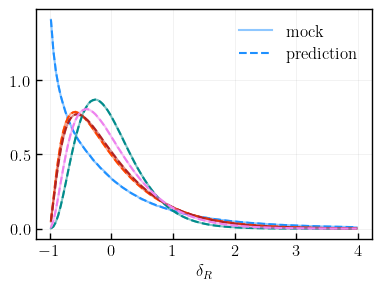

In [ ]:
plt.figure(figsize=(4, 3))
# let's plot some predictions vs truth
for i in range(5):
    plt.plot(delta, lhc_test_y.T[:, i], color='C{}'.format(i), alpha=0.5, label='mock' if i==0 else '')
    plt.plot(delta, pred_test_y.T[:, i], color='C{}'.format(i), ls='--', label='prediction' if i==0 else '')
plt.xlabel(r'$\delta_R$')
plt.legend()
plt.show()

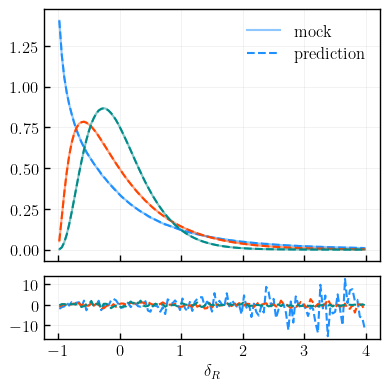

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True, height_ratios=(4, 1))
# let's plot some predictions vs truth
for i in range(3):
    ax[0].plot(delta, lhc_test_y.T[:, i], color='C{}'.format(i), alpha=0.5, label='mock' if i==0 else '')
    ax[0].plot(delta, pred_test_y.T[:, i], color='C{}'.format(i), ls='--', label='prediction' if i==0 else '')
    ax[1].plot(delta, (lhc_test_y.T[:, i]-pred_test_y.T[:, i])/std_pdf, color='C{}'.format(i), ls='--', label='prediction' if i==0 else '')
plt.xlabel(r'$\delta_R$')
#ax[0].set_xlim(-1, 3)
ax[0].legend()
plt.show()

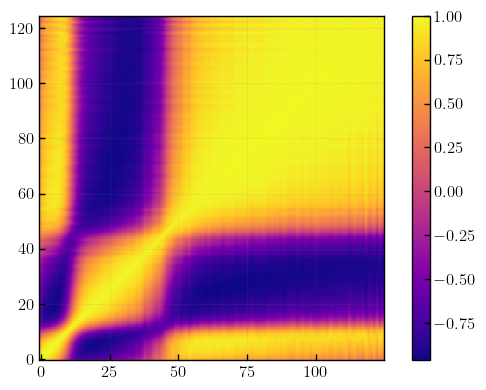

In [ ]:
correlation_matrix = np.corrcoef(np.array(cov_pdf).T)

plt.imshow(correlation_matrix, origin='lower')
#plt.xlabel(r'$\delta_R$')
#plt.ylabel(r'$\delta_R$')
plt.colorbar()
plt.show()

In [ ]:
cov_pdf.shape

(125, 125)

In [ ]:
np.linalg.matrix_rank(cov_pdf)

125

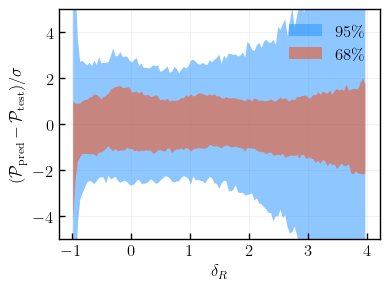

In [ ]:
q68 = np.quantile(emulator_error, [0.16, 0.84], axis=0)
q95 = np.quantile(emulator_error, [0.025, 0.975], axis=0)
q99 = np.quantile(emulator_error, [0.005, 0.995], axis=0)

plt.figure(figsize=(4, 3))
plt.fill_between(delta, q95[0], q95[1], alpha=0.5, label='95\%',)
plt.fill_between(delta, q68[0], q68[1], alpha=0.5, label='68\%',) 
plt.legend()
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$(\mathcal{P}_{\mathrm{pred}} - \mathcal{P}_{\mathrm{test}})/\sigma$')
plt.ylim(-5, 5)
plt.show()